In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
train_df = pd.read_csv("D:/mygit/Kaggle/Zillow_Home_Value_Prediction/train_2016_v2.csv",parse_dates=['transactiondate'])

In [3]:
train_df.shape

(90275, 3)

In [4]:
train_df.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


###### logerror
需要预测的目标变量,先开始研究ta吧

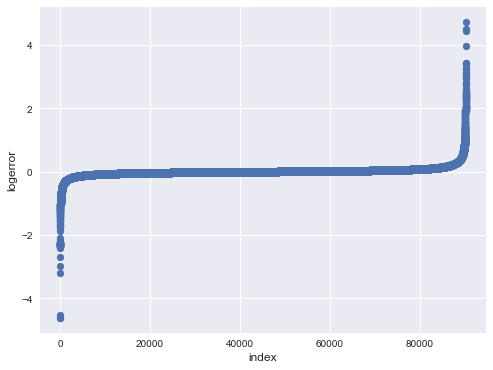

In [10]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]),np.sort(train_df.logerror.values))
plt.xlabel('index',fontsize=12)
plt.ylabel('logerror',fontsize=12)
plt.show()

logerror 基本上是在 “0”附近分布，两边都存在一些异常值。  
logerror < -4     logerror > 3.x?

In [19]:
ulimit = np.percentile(train_df.logerror.values,99)
llimit = np.percentile(train_df.logerror.values,1)
# 获取logerror的99分位数，1分位数的值
# 99%的数据大于-0.3425
# 1%的数据大于0.463882

In [20]:
# 把异常数据定义为百分位数
train_df['logerror'].ix[train_df['logerror']>ulimit] = ulimit
train_df['logerror'].ix[train_df['logerror']<llimit] = llimit

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


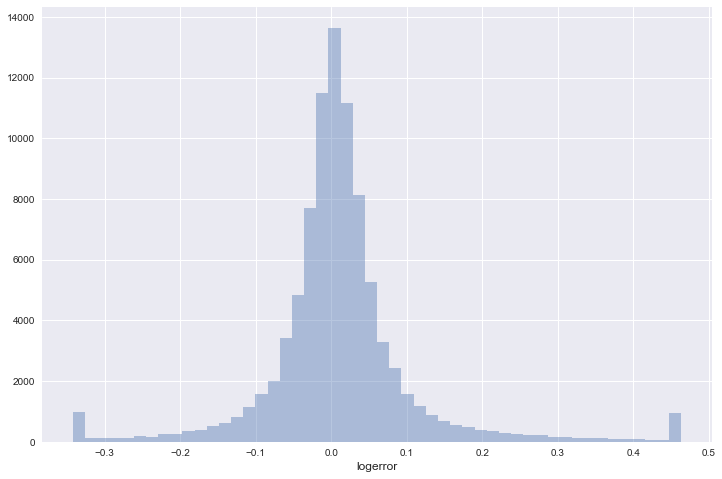

In [21]:
plt.figure(figsize=(12,8))
sns.distplot(train_df.logerror.values,bins=50,kde=False)
plt.xlabel('logerror',fontsize=12)
plt.show()

挺标准的正态分布，如果去除掉异常数据的话

In [22]:
# 获取每一个交易的月份
train_df['transaction_month'] = train_df['transactiondate'].dt.month

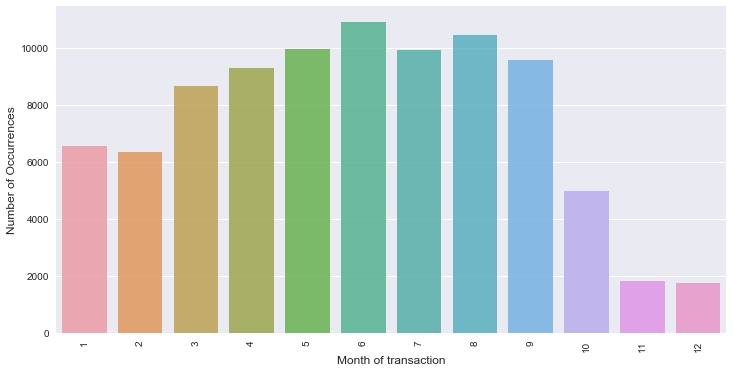

In [23]:
cnt_srs = train_df['transaction_month'].value_counts()
plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index,cnt_srs.values,alpha=0.8)
plt.xticks(rotation='vertical')
plt.xlabel('Month of transaction',fontsize=12)
plt.ylabel('Number of Occurrences',fontsize=12)
plt.show()

比赛说明：The train data has all the transactions before October 15, 2016, plus some of the transactions after October 15, 2016.  
所以11月、12月的数据相对较少

In [26]:
# parcelid 房屋id
# 统计房屋ID出现的次数
(train_df['parcelid'].value_counts().reset_index())['parcelid'].value_counts()

1    90026
2      123
3        1
Name: parcelid, dtype: int64

#### parcelid
大部分的数据都是出现1次，说明在时间段内房屋只交易了一次。
但是也有的房屋交易次数出现了3次

In [27]:
# 读取物业房屋的物业数据
prop_df = pd.read_csv('D:/mygit/Kaggle/Zillow_Home_Value_Prediction/properties_2016.csv')
prop_df.shape

D:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(2985217, 58)

In [28]:
prop_df.head()
# 缺失值挺多的...

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


In [31]:
# 每个特征下，数据缺失的数量
prop_df.isnull().sum(axis=0).reset_index()

,index,0
0,parcelid,0
1,airconditioningtypeid,2173698
2,architecturalstyletypeid,2979156
3,basementsqft,2983589
4,bathroomcnt,11462
5,bedroomcnt,11450
6,buildingclasstypeid,2972588
7,buildingqualitytypeid,1046729
8,calculatedbathnbr,128912
9,decktypeid,2968121


In [32]:
missing_df = prop_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['featureName','count']
missing_df = missing_df.ix[missing_df['count'] > 0] # 其实只有id是没有缺失值的
missing_df = missing_df.sort_values(by='count')     # 排序

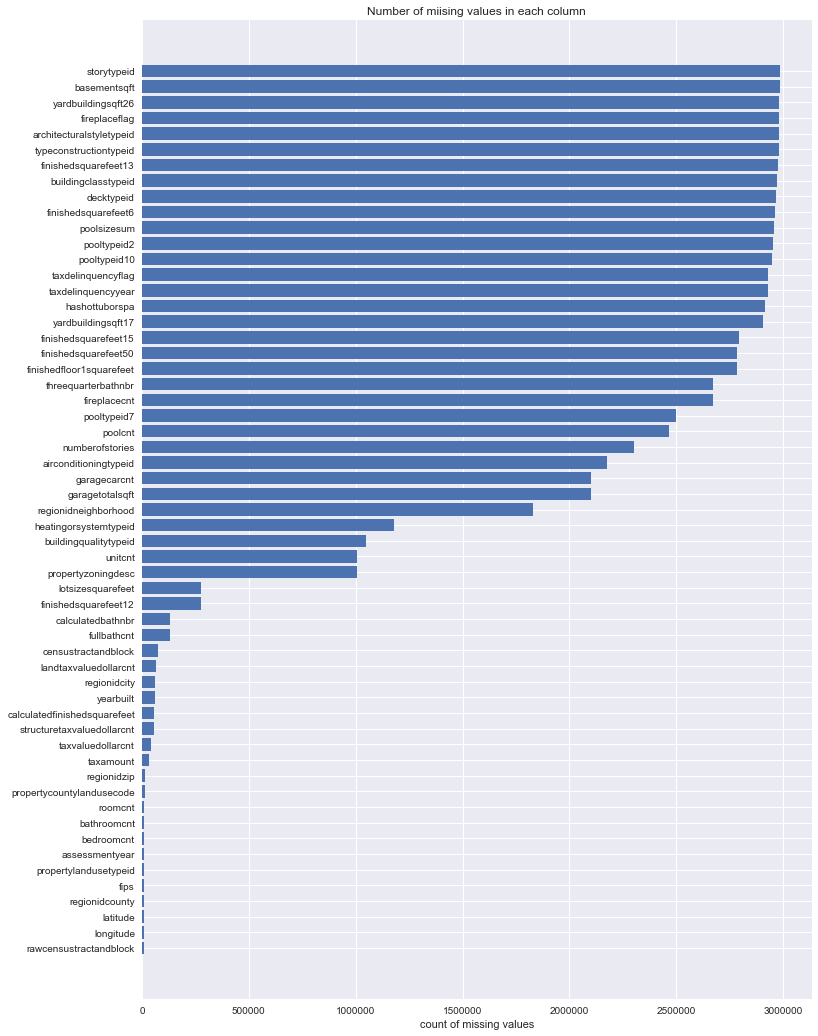

In [41]:
ind = np.arange(missing_df.shape[0])
width = 0.9
fig , ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind,missing_df['count'].values)
ax.set_yticks(ind)
ax.set_yticklabels(missing_df['featureName'].values,rotation='horizontal')
ax.set_xlabel('count of missing values')
ax.set_title('Number of miising values in each column')
plt.show()

In [45]:
# 展示一下每个特征的缺失数据率
missing_df['lossvalueRate'] = missing_df['count']/prop_df.shape[0]
missing_df

,featureName,count,lossvalueRate
35,rawcensustractandblock,11437,0.003831
25,longitude,11437,0.003831
24,latitude,11437,0.003831
37,regionidcounty,11437,0.003831
17,fips,11437,0.003831
33,propertylandusetypeid,11437,0.003831
52,assessmentyear,11439,0.003832
5,bedroomcnt,11450,0.003836
4,bathroomcnt,11462,0.003840
40,roomcnt,11475,0.003844


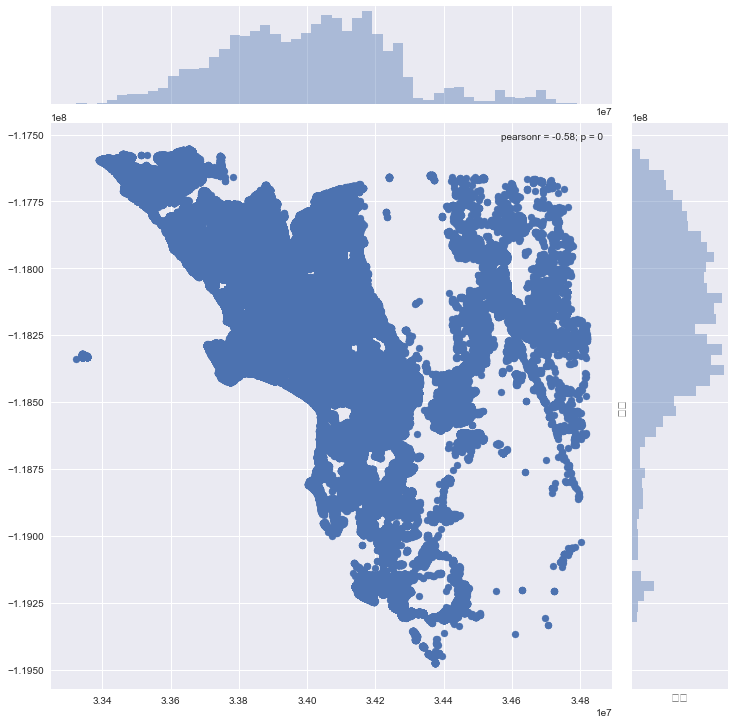

In [46]:
# 查看经纬度~
plt.figure(figsize=(12,12))
sns.jointplot(x=prop_df.latitude.values,y=prop_df.longitude.values,size=10)
plt.ylabel('经度',fontsize=12)
plt.xlabel('维度',fontsize=12)
plt.show()

说实话真没看出来神马~~

In [47]:
# 合并数据
train_df = pd.merge(train_df,prop_df,on='parcelid',how='left')
train_df.shape

(90275, 61)

In [48]:
# 查看每个特征的数据类型
pd.options.display.max_rows = 65
dtype_df = train_df.dtypes.reset_index()
dtype_df.columns = ['Count','ColumnType']
dtype_df

,Count,ColumnType
0,parcelid,int64
1,logerror,float64
2,transactiondate,datetime64[ns]
3,transaction_month,int64
4,airconditioningtypeid,float64
5,architecturalstyletypeid,float64
6,basementsqft,float64
7,bathroomcnt,float64
8,bedroomcnt,float64
9,buildingclasstypeid,float64


In [54]:
# 统计不同数据类型的特征数,大部分都是float64
# 用float64 保存数据有点浪费吧~
dtype_df.groupby('ColumnType').aggregate('count').reset_index()

,ColumnType,Count
0,int64,2
1,float64,53
2,datetime64[ns],1
3,object,5


# 查看合并后的缺失值的情况
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name','missing_count']
missing_df['missing_ratio'] = missing_df['missing_count']/train_df.shape[0]
missing_df.ix[missing_df['missing_ratio'] > 0.999]

这个就可以删掉了吧~

In [57]:
missing_df.ix[missing_df['missing_ratio'] > 0.95]

,column_name,missing_count,missing_ratio
5,architecturalstyletypeid,90014,0.997109
6,basementsqft,90232,0.999524
9,buildingclasstypeid,90259,0.999823
12,decktypeid,89617,0.992711
16,finishedsquarefeet13,90242,0.999634
17,finishedsquarefeet15,86711,0.960521
19,finishedsquarefeet6,89854,0.995336
25,hashottuborspa,87910,0.973802
31,poolsizesum,89306,0.989266
32,pooltypeid10,89114,0.987139


In [58]:
# 暂时使用平均值来评估缺失值吧
# 正式开始的时候要研究每个特征代表的意义后决定如何处理缺失数据
mean_values = train_df.mean(axis=0)
train_df_new = train_df.fillna(mean_values,inplace=True) # train_df 之后还会用到

In [59]:
# 查看变量间的相关性
# 不是目标变量、且数据类型是float64的特征
x_cols = [col for col in train_df_new.columns if col not in ['logerror'] if train_df_new[col].dtype=='float64']
x_cols

['airconditioningtypeid',
 'architecturalstyletypeid',
 'basementsqft',
 'bathroomcnt',
 'bedroomcnt',
 'buildingclasstypeid',
 'buildingqualitytypeid',
 'calculatedbathnbr',
 'decktypeid',
 'finishedfloor1squarefeet',
 'calculatedfinishedsquarefeet',
 'finishedsquarefeet12',
 'finishedsquarefeet13',
 'finishedsquarefeet15',
 'finishedsquarefeet50',
 'finishedsquarefeet6',
 'fips',
 'fireplacecnt',
 'fullbathcnt',
 'garagecarcnt',
 'garagetotalsqft',
 'heatingorsystemtypeid',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'poolcnt',
 'poolsizesum',
 'pooltypeid10',
 'pooltypeid2',
 'pooltypeid7',
 'propertylandusetypeid',
 'rawcensustractandblock',
 'regionidcity',
 'regionidcounty',
 'regionidneighborhood',
 'regionidzip',
 'roomcnt',
 'storytypeid',
 'threequarterbathnbr',
 'typeconstructiontypeid',
 'unitcnt',
 'yardbuildingsqft17',
 'yardbuildingsqft26',
 'yearbuilt',
 'numberofstories',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'assessmentyear',
 'landtaxvaluedollar

In [60]:
labels = []
values = []
for col in x_cols:
    labels.append(col)
    # 每个变量和目标变量的相关性系数
    values.append(np.corrcoef(train_df_new[col].values,train_df_new.logerror.values)[0,1])
# 转换成数据框
corr_df = pd.DataFrame({'col_labels':labels,'corr_values':values})
# 排序
corr_df = corr_df.sort_values(by='corr_values')

D:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2569: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2570: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


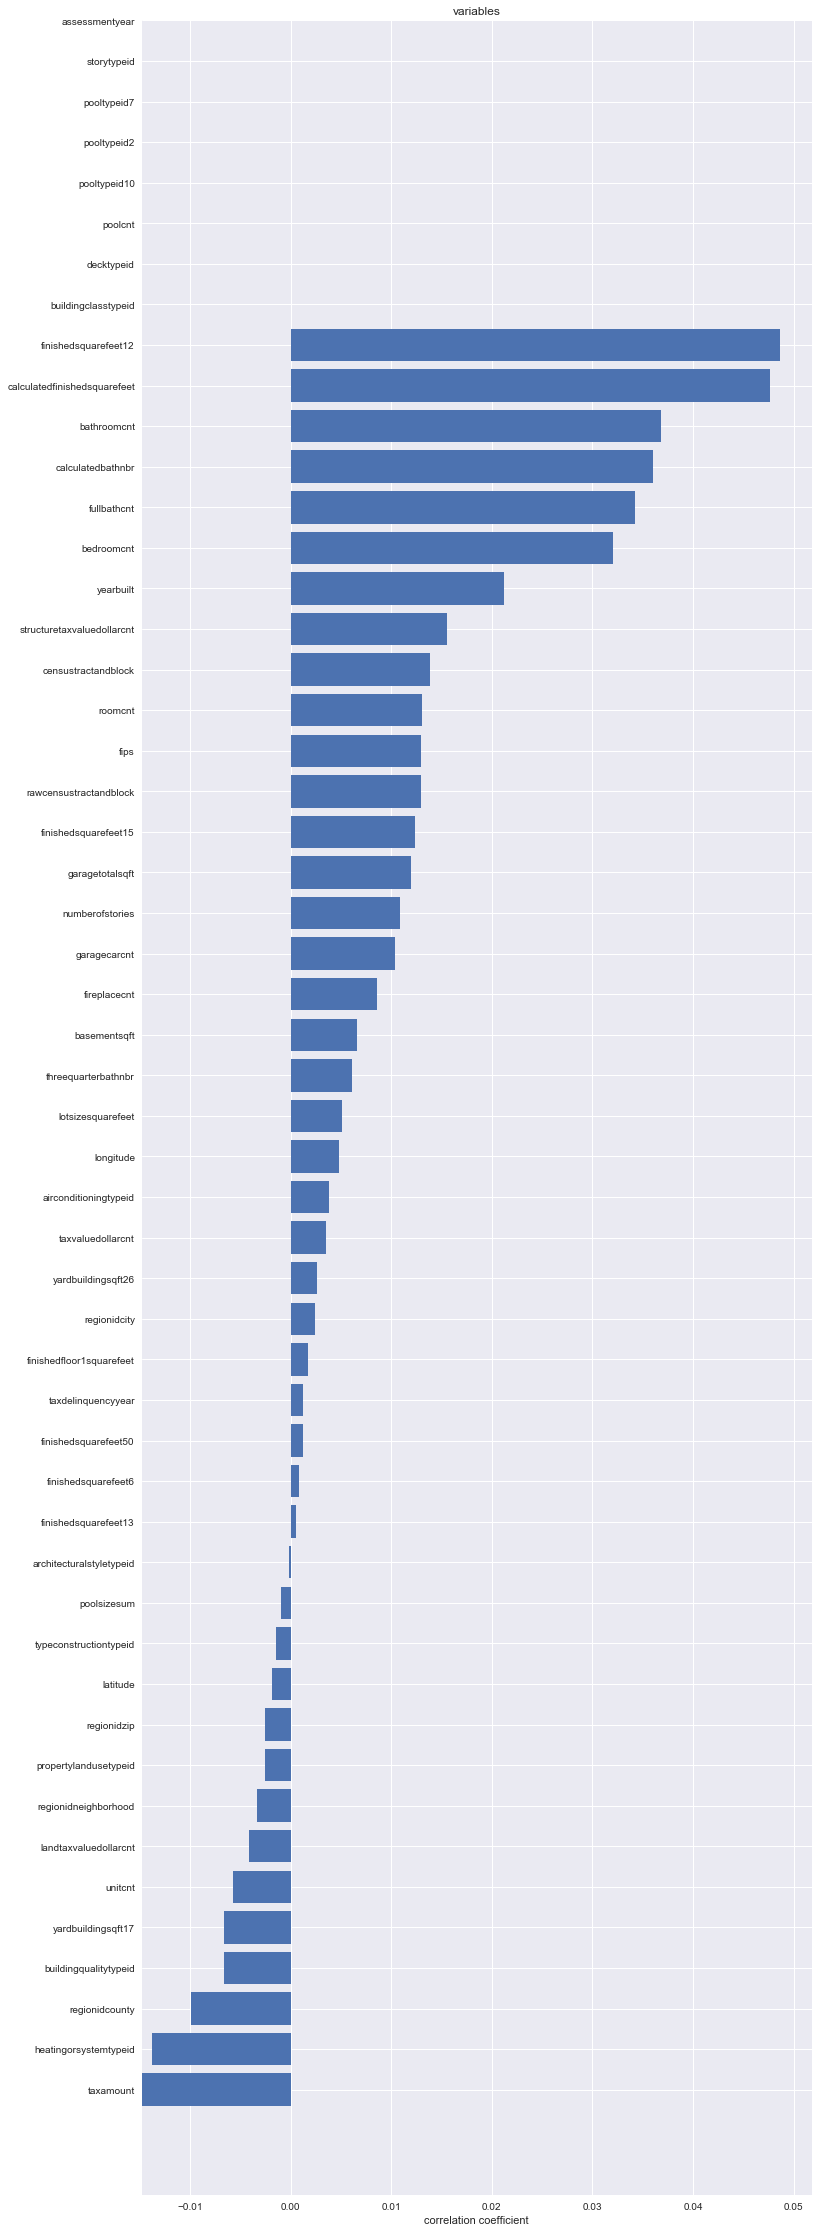

In [61]:
# 相关性画下图
ind = np.arange(len(labels))
width = 0.9
fig,ax = plt.subplots(figsize=(12,40))
rects = ax.barh(ind,np.array(corr_df.corr_values.values))
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values,rotation='horizontal')
ax.set_xlabel('correlation coefficient')
ax.set_title('variables')
plt.show()

有8个特征与目标变量没有任何相关性~~~ 应该是只有一个值，要不就是缺失值NaN  
另外所有的特征的想关心都在-0.02 —— 0.05之间，挺低的

In [62]:
corr_zero_cols = ['assessmentyear', 'storytypeid', 'pooltypeid2', 'pooltypeid7', 'pooltypeid10', 'poolcnt', 'decktypeid', 'buildingclasstypeid']
for col in corr_zero_cols:
    # 获取上面这几个特征的唯一值的数量
    print (col,len(train_df_new[col].unique()))

assessmentyear 1
storytypeid 1
pooltypeid2 1
pooltypeid7 1
pooltypeid10 1
poolcnt 1
decktypeid 1
buildingclasstypeid 1


In [63]:
# 获取相对高点的
corr_df_sel = corr_df.ix[(corr_df['corr_values'] > 0.02) | (corr_df['corr_values']<-0.01)]
corr_df_sel

,col_labels,corr_values
49,taxamount,-0.014768
21,heatingorsystemtypeid,-0.013732
43,yearbuilt,0.021171
4,bedroomcnt,0.032035
18,fullbathcnt,0.034267
7,calculatedbathnbr,0.036019
3,bathroomcnt,0.036862
10,calculatedfinishedsquarefeet,0.047659
11,finishedsquarefeet12,0.048611


In [67]:
cols_to_use = corr_df_sel.col_labels.tolist()
# 高相关性特征的数据
temp_df = train_df[cols_to_use]

In [69]:
# 相关性矩阵
corrmat = temp_df.corr(method='spearman')

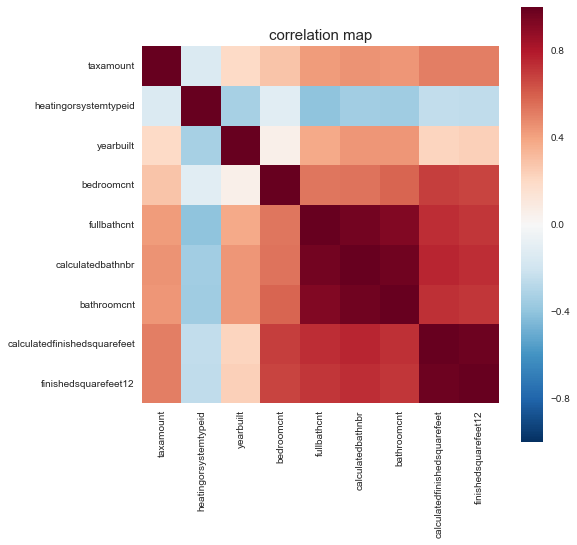

In [70]:
# 画图~
f,ax = plt.subplots(figsize=(8,8))
sns.heatmap(corrmat,vmax=1,square=True)
plt.title('correlation map',fontsize=15)
plt.show()

对单个变量进行研究  
finishedsquarefeet12 : Base unfinished and finished area  
这个是官方给出的解释。。。。鬼TM才知道神马意思

In [71]:
col = 'finishedsquarefeet12'
ulimit = np.percentile(train_df[col].values,99.5) # 99.5分位数
llimit = np.percentile(train_df[col].values,0.5)
train_df[col].ix[train_df[col] > ulimit] = ulimit
train_df[col].ix[train_df[col] < llimit] = llimit

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


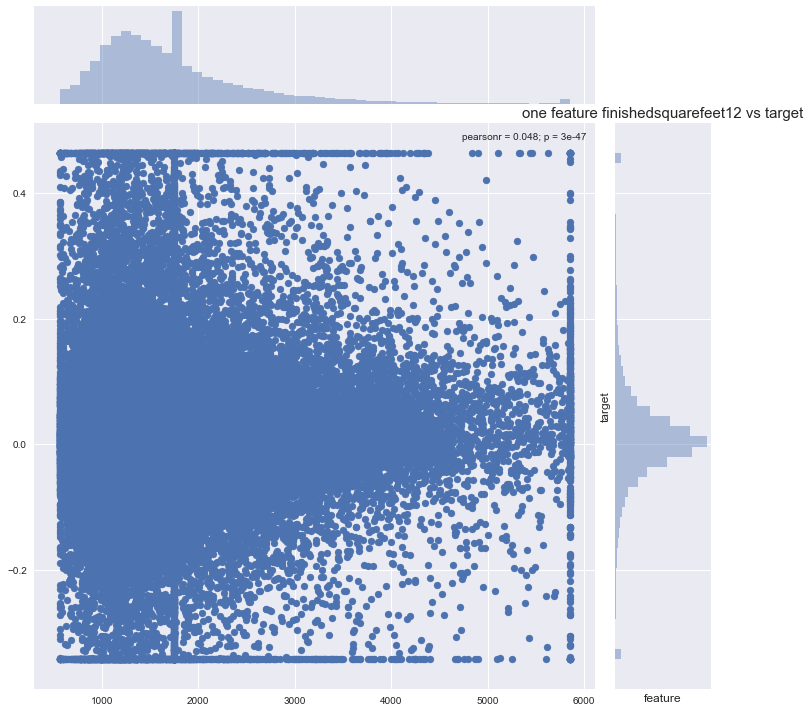

In [72]:
plt.figure(figsize=(12,12))
sns.jointplot(x=train_df.finishedsquarefeet12.values,y=train_df.logerror.values,size=10)
plt.ylabel('target',fontsize=12)
plt.xlabel('feature',fontsize=12)
plt.title('one feature finishedsquarefeet12 vs target',fontsize=15)
plt.show()

貌似随着这个feature的增加，目标变量的变化区间越来越小。

calculatedfinishedsquarefeet： Calculated total finished living area of the home  
官方给出的字段说明，应该是住房的总居住面积

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


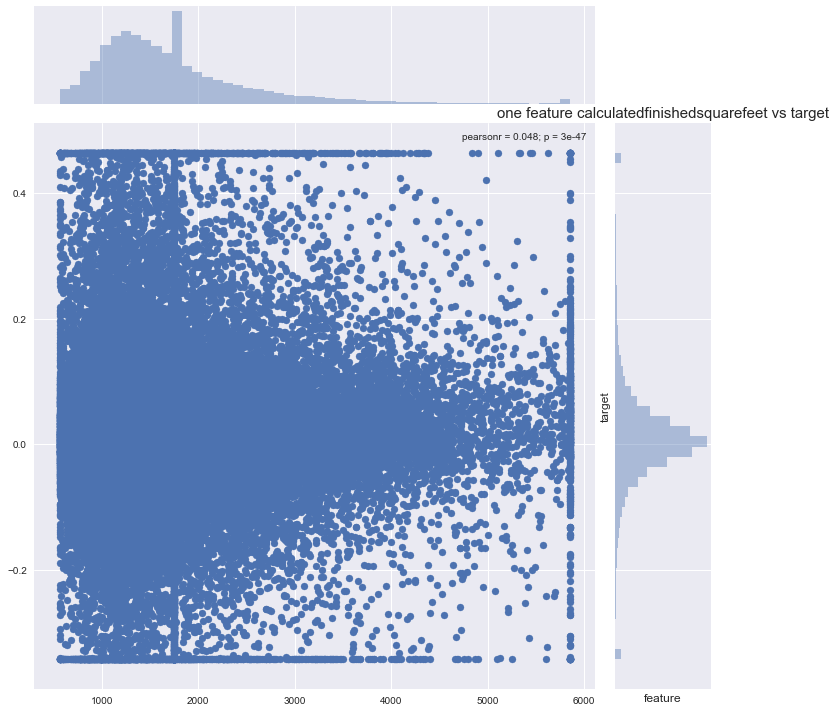

In [73]:
col = 'calculatedfinishedsquarefeet'
ulimit = np.percentile(train_df[col].values,99.5)
llimit = np.percentile(train_df[col].values,0.5)
train_df[col].ix[train_df[col] > ulimit] = ulimit
train_df[col].ix[train_df[col] < llimit] = llimit
plt.figure(figsize=(12,12))
sns.jointplot(x=train_df.finishedsquarefeet12.values,y=train_df.logerror.values,size=10)
plt.ylabel('target',fontsize=12)
plt.xlabel('feature',fontsize=12)
plt.title('one feature calculatedfinishedsquarefeet vs target',fontsize=15)
plt.show()

calculatedfinishedsquarefeet 和 finishedsquarefeet12与目标变量的分布看起来很像，所以在correlation map中，这两个变量的相关性会很红红红~

correlation map 中另外还有一个区域比较红红红的  
是这三个feature：  
    1. fullbathcnt  
    2. calculatedbathnbr  
    3. bathroomcnt  
看名字就应该直到，是房屋的浴室的相关特征

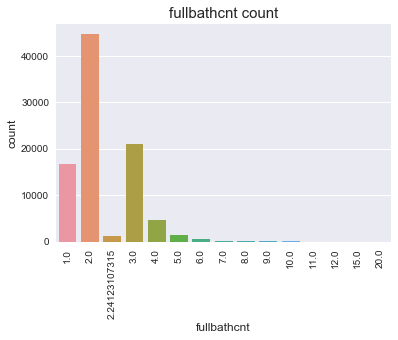

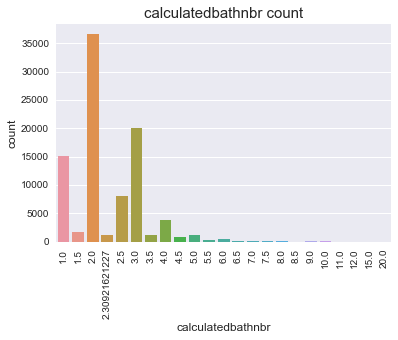

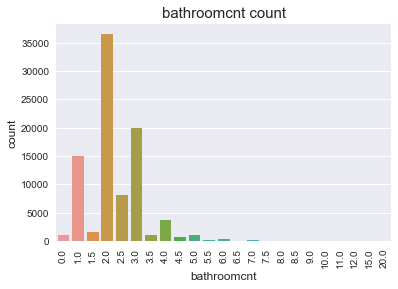

In [79]:
for i in ['fullbathcnt','calculatedbathnbr','bathroomcnt']:
    sns.countplot(x=i,data=train_df)
    plt.ylabel('count',fontsize=12)
    plt.xlabel(i,fontsize=12)
    plt.xticks(rotation='vertical')
    plt.title('%s count' % i,fontsize=15)
    plt.show()

其实这三个分布也是挺类似的  
另外因为是用均值填充缺失值，所有会有些看起来很怪的值，例如2.3091……  

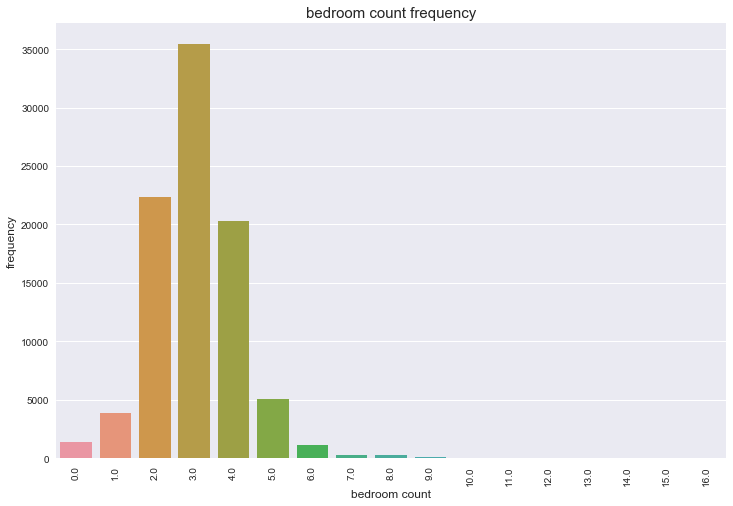

In [81]:
col = 'bedroomcnt'
plt.figure(figsize=(12,8))
sns.countplot(x=col,data=train_df)
plt.ylabel('frequency',fontsize=12)
plt.xlabel('bedroom count',fontsize=12)
plt.xticks(rotation='vertical')
plt.title('bedroom count frequency',fontsize=15)
plt.show()

卧室数量，最多的是3个~~~~  
分布看上去还挺好的，是不是可以....让缺失值服从这个分布形式呢~

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


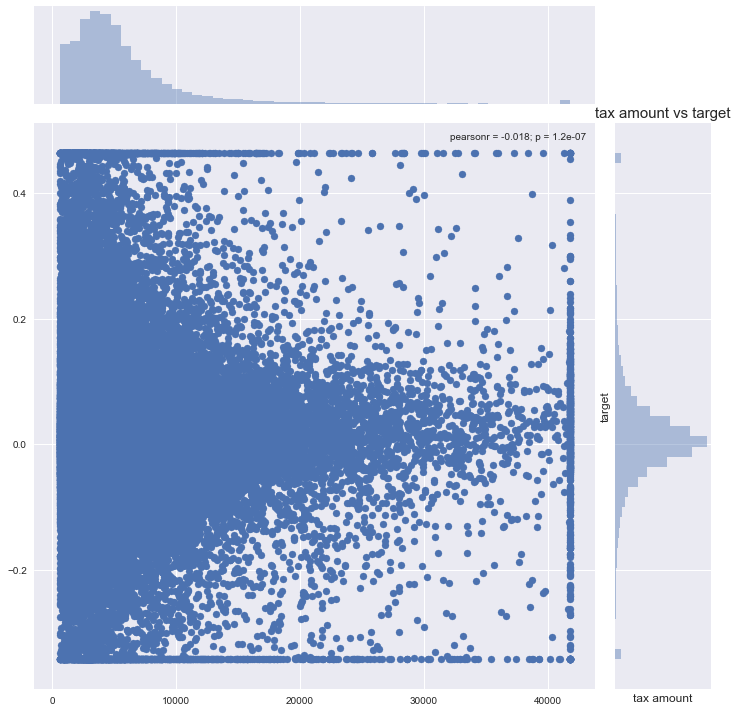

In [82]:
col = 'taxamount'
ulimit = np.percentile(train_df[col].values,99.5)
llimit = np.percentile(train_df[col].values,0.5)
train_df[col].ix[train_df[col] > ulimit] = ulimit
train_df[col].ix[train_df[col] < llimit] = llimit
plt.figure(figsize=(12,12))
sns.jointplot(x=train_df[col].values,y=train_df['logerror'].values,size=10)
plt.ylabel('target',fontsize=12)
plt.xlabel('tax amount' ,fontsize=12)
plt.title('tax amount vs target',fontsize=15)
plt.show()

taxamount：The total property tax assessed for that assessment year  
官方给出来的说法应该是，房屋的税有关的一个特征  
和之前的一些特征类似，随着特征值增加，目标变量的变化区间越小


D:\Anaconda3\lib\site-packages\ggplot\stats\stat_smooth.py:77: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  smoothed_data = smoothed_data.sort('x')


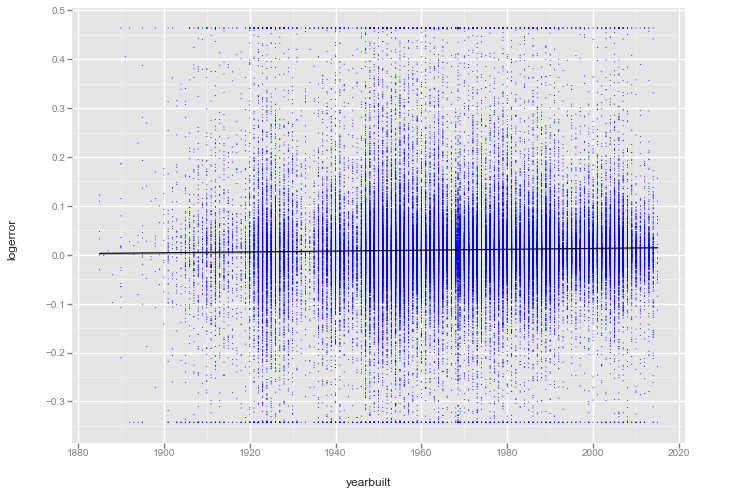

<ggplot: (-9223371927303194613)>

In [84]:
from ggplot import *
ggplot(aes(x='yearbuilt',y='logerror'),data=train_df) + geom_point(color='blue',size=1) + stat_smooth()

房屋建造时间与目标变量的变化关系  
貌似有一点微微地增长，但是建造时间更多的集中在1970年左右应该  
总体上，感觉每一年的目标变量分布，大致还是整体分布~  

In [85]:
# 基于模型的特征选择，利用extratree 和 xgboost
from sklearn.ensemble import ExtraTreesRegressor
import xgboost as xgb

# 准备数据
train_y = train_df['logerror'].values
cat_cols = ["hashottuborspa", "propertycountylandusecode", "propertyzoningdesc", "fireplaceflag", "taxdelinquencyflag"]
# 删掉一些特征
train_df = train_df.drop(['parcelid','logerror','transactiondate', 'transaction_month'] + cat_cols , axis=1)
feat_names = train_df.columns.values

dtrain = xgb.DMatrix(train_df,train_y,feature_names=train_df.columns.values)

In [86]:
# 训练模型
model_ETR = ExtraTreesRegressor(n_estimators=25,max_depth=30,max_features=0.3,n_jobs=-1,random_state=0)
model_ETR.fit(train_df,train_y)

xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'silent': 1,
    'seed' : 0
}
model_XGB = xgb.train(dict(xgb_params,silent=0),dtrain,num_boost_round=50)

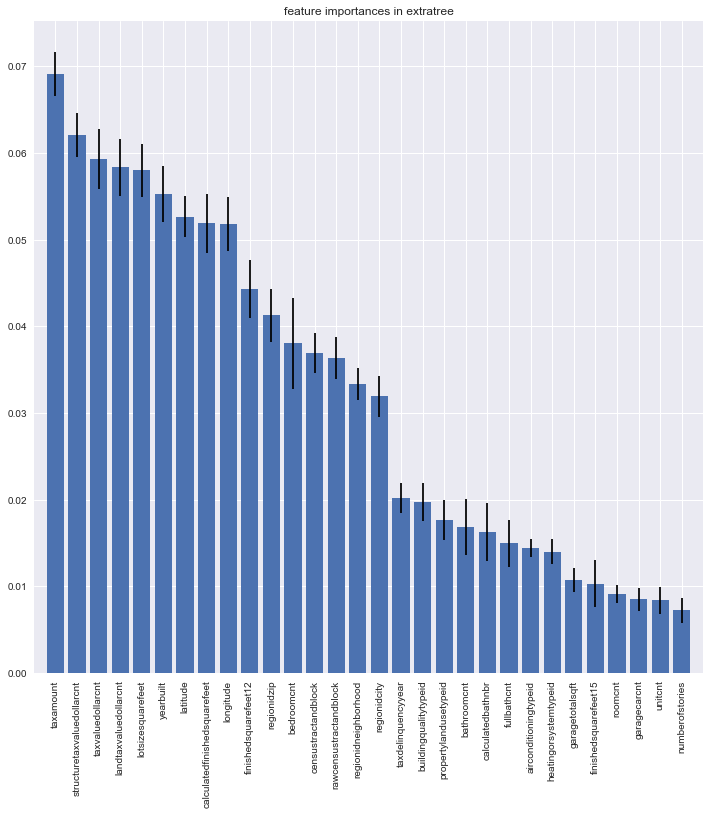

In [90]:
# 绘制特征的重要程度
# extraTreesRegressor
importances = model_ETR.feature_importances_
# 一共有25个评估器，获取每个评估器的特征重要性后计算标准偏差
std = np.std([tree.feature_importances_ for tree in model_ETR.estimators_],axis=0)
# 前三十个最重要的特征的编号
indices = np.argsort(importances)[::-1][:30]
plt.figure(figsize=(12,12))
plt.title('feature importances in extratree')
plt.bar(range(len(indices)),importances[indices],yerr=std[indices],align='center')
plt.xticks(range(len(indices)) ,feat_names[indices],rotation='vertical')
plt.xlim([-1,len(indices)])
plt.show()

taxamount\structuretaxvaluedollarcnt\taxvaluedollarcnt 是对于extratree来说前三重要的特征

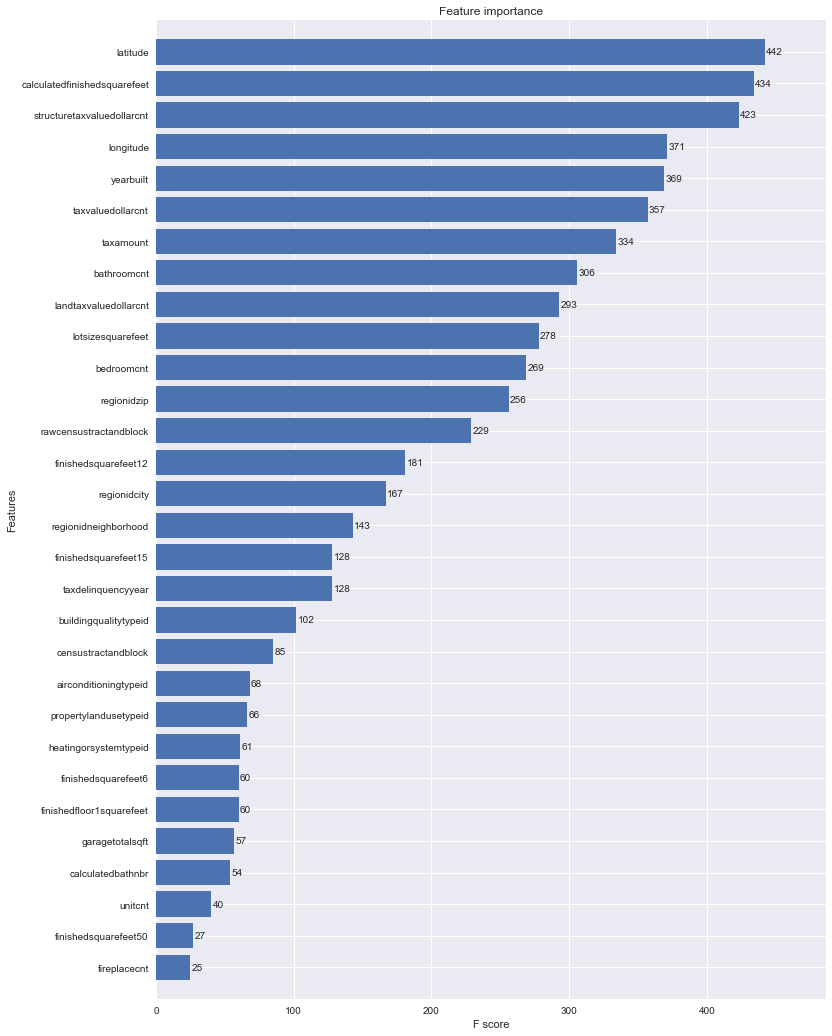

In [118]:
# 绘制特征的重要程度
# xgboost
fig,ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model_XGB,max_num_features=30,height=0.8,ax=ax)
plt.show()

latitude/calculatedfinishedsquarefeet/structuretaxvaluedollarcnt 是三个对xgboost来说比较重要的特征